In [184]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pandas as pd
from src.utils import get_generations, get_metrics, get_all, _process_evalharness_results, get_superglue_results, get_empirical_cdf

# Helper Functions

In [185]:

def _get_param_corruption(dirname):
    """
    Get the corruption parameter from the directory name
    """
    res_val = re.search("_res_(False|True)", dirname).group(1)
    num_toks = re.search("_tok_(\d+)", dirname).group(1)
    return (res_val, int(num_toks))
    
    


# Getting Data

In [192]:

# parent = './amlt/08-31-corrupt-start-lm'
# parent = './amlt/08-31-corrupt-start-proj'

parent = './amlt/08-31-corrupt-random-lm'
# parent = './amlt/08-31-corrupt-random-proj'

restricted = False
# restricted = True


corruption_type = os.path.basename(parent).split('-')[-2]
watermark_layer = os.path.basename(parent).split('-')[-1]
title_addition = f"({corruption_type}, {watermark_layer})"

generations = get_generations(parent, _get_params=_get_param_corruption)


min_prob = 1e-14
data = {key: get_all(value, min_prob) for key, value in generations.items()}

if watermark_layer == 'lm':
    uncorrupted_generations = get_generations('./amlt/watermark_llama_lm')[('-1_mlp_none', 1e-05)]
    uncorrupted_data = get_all(uncorrupted_generations, min_prob)
elif watermark_layer == 'proj':
    uncorrupted_generations = get_generations('./amlt/08-30-llama-watermark-early/')[('31_mlp_down_proj', 1e-04)]
    uncorrupted_data = get_all(uncorrupted_generations, min_prob)
else:
    raise ValueError(f"Unknown watermark layer {watermark_layer}")


/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.p

# Summary Statistics

In [194]:
sig_level = 0.01
print(f"Significance level: {sig_level}")
print(title_addition  + ' ' + "#" * 50)
frac_uncorrupted_passed = np.sum(uncorrupted_data['pvalue'] < sig_level) / len(uncorrupted_data['pvalue'])
print(f"Uncorrupted: {frac_uncorrupted_passed:.4f}\n")

for key, datum in data.items():
    if key[0] != str(restricted):
        continue
    
    prefix = 'Average p-values'
    if key[0] == 'True':
        prefix += '(Restricted)'
    else:
        prefix += '(Unrestricted)'
    prefix += f' with {key[1]} corrupted tokens'

    frac_passed = np.sum(datum['pvalue'] < sig_level) / len(datum['pvalue'])

    prefix += f": {frac_passed:.4f}"
    print(prefix)

Significance level: 0.01
(random, lm) ##################################################
Uncorrupted: 0.9350

Average p-values(Unrestricted) with 10 corrupted tokens: 0.8540
Average p-values(Unrestricted) with 50 corrupted tokens: 0.5920
Average p-values(Unrestricted) with 100 corrupted tokens: 0.3590


# Plotting

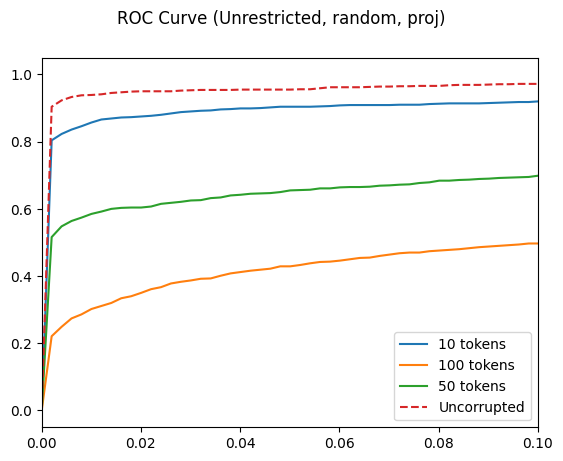

In [188]:
grid_size = 500
fig, ax = plt.subplots()


for key, datum in data.items():
    if key[0] != str(restricted):
        continue
    grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=grid_size)
    
    label = f'{key[1]} tokens'

    ax.plot(grid, cdf, label=label)


grid, cdf = get_empirical_cdf(uncorrupted_data['pvalue'], grid_size=grid_size)
ax.plot(grid, cdf, label='Uncorrupted', linestyle='--')

ax.legend()
title = 'ROC Curve'
if restricted:
    title += ' (Restricted, '
else:
    title += ' (Unrestricted, '
title += title_addition[1:]
fig.suptitle(title)

ax.set_xlim(0,0.1)
plt.show()

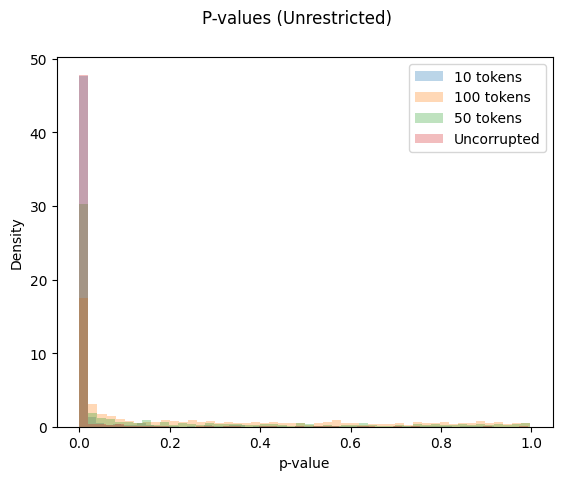

In [189]:
alpha = 0.3
bins=50

fig, ax = plt.subplots()
for key, datum in data.items():
    if key[0] != str(restricted):
        continue


    ax.hist(datum['pvalue'], bins=bins, alpha=alpha, label=f'{key[1]} tokens', density=True)


ax.hist(uncorrupted_data['pvalue'], bins=bins, alpha=alpha, label='Uncorrupted', density=True)

ax.legend()
ax.set_xlabel('p-value')
ax.set_ylabel('Density')

title = "P-values"
if restricted:
    title += ' (Restricted)'
else:
    title += ' (Unrestricted)'


fig.suptitle(title)

plt.show()

# Example Generations

In [190]:
token_list = {key[1] for key in data.keys() if key[0] == str(restricted)}
idx = np.random.choice(len(datum['pvalue']))
print(f"Random index: {idx}\n")
for i in token_list:
    gen = generations[(str(restricted), i)]
    prompts, responses = [], []
    example = gen[idx]
    prompt = example['prompt']
    response = example['response']
    print(f"Token count: {i}")
    print(prompt + response + '\n')


gen = uncorrupted_generations
prompts, responses = [], []
example = gen[idx]
prompt = example['prompt']
response = example['response']
print(f"Uncorrupted")
print(prompt + response + '\n')

Random index: 135

Token count: 10
Maddie Hinch and her England team-mates should be proud of their Hockey Women’s World Cup exploits, ­according to Bob ­Omarperimental.
 GuerThe 19-year-old midfielder has returned home from the Netherlands where England lost 6-0 to reigningobox champions the Netherlands in the semi-finals.
The Redcar-based Wald coach had high hopes for his players ahead of the tournament, which marks the first time Great Britain have beenток represented in women’s competition for 20 years.
“It’s been an excellent tournament and the players should be very proud of how they have performed and how they have behaved,” said Omar.
“The whole squad have left their mark and their mark on their team-mates, and their team-mates have really grown into them.
England lost both of their matches against the Netherlands in the pool stage, but Omar says the side can reflect on some of their performances as major positives from the tournament.
“Having the youngestح team, going to a maj